<a href="https://colab.research.google.com/github/anushkayeole24/Innomatics-Data-Science-Internship/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis of Real-time Flipkart Product Reviews** with emoji

## Objective
The objective of this project is to classify customer reviews as positive or negative and understand the pain points of customers who write negative reviews. By analyzing the sentiment of reviews, we aim to gain insights into product features that contribute to customer satisfaction or dissatisfaction.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn import svm

###Loading DATA

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drb = pd.read_csv("/content/drive/MyDrive/sentiment analysis of flipkart/reviews_badminton/data.csv")

In [ ]:
drb.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [ ]:
drb.columns

Index(['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes',
       'Down Votes', 'Month', 'Review text', 'Ratings'],
      dtype='object')

###drb dataframe missing values handling process

In [ ]:
print(drb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB
None


In [ ]:
#missing values in the dataset
missing_values = drb.isnull().sum()
for column, count in missing_values.items():
    if count > 0:
        print(f"Column '{column}' has {count} missing value(s).")
total_missing = missing_values.sum()
print(f"Total missing values in the dataset: {total_missing}")


Column 'Reviewer Name' has 10 missing value(s).
Column 'Review Title' has 10 missing value(s).
Column 'Place of Review' has 50 missing value(s).
Column 'Up Votes' has 10 missing value(s).
Column 'Down Votes' has 10 missing value(s).
Column 'Month' has 465 missing value(s).
Column 'Review text' has 8 missing value(s).
Total missing values in the dataset: 563


In [ ]:
# Impute missing values
drb['Reviewer Name'].fillna('Unknown', inplace=True)
drb['Review Title'].fillna('No Title', inplace=True)
drb['Place of Review'].fillna('Unknown', inplace=True)
drb['Up Votes'].fillna(drb['Up Votes'].median(), inplace=True)  # Fill with median
drb['Down Votes'].fillna(drb['Down Votes'].median(), inplace=True)  # Fill with median
drb['Month'].fillna('Unknown', inplace=True)
drb['Review text'].fillna('', inplace=True)  # Fill with empty string for text data

# Check if missing values have been handled
missing_values_after_imputation = drb.isnull().sum()
total_missing_after_imputation = missing_values_after_imputation.sum()
print(f"Total missing values in the dataset after imputation: {total_missing_after_imputation}")


Total missing values in the dataset after imputation: 0


###handling emojis

In [ ]:
# Function to find emojis in text
def find_emojis(text):
    # Define regex pattern to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

# Apply the function to find emojis in each review text
drb['Emojis'] = drb['Review text'].apply(find_emojis)

# Display reviews containing emojis
reviews_with_emojis = drb[drb['Emojis'].apply(len) > 0]
print("Reviews containing emojis:")
print(reviews_with_emojis[['Review text', 'Emojis']])


Reviews containing emojis:
                                            Review text        Emojis
14    really satisfied with the quality and the prom...           [👍]
55              Low quality very bad quality 😡READ MORE           [😡]
69                          Very bad quality 👎READ MORE           [👎]
88                                 it's awsm 😎READ MORE           [😎]
103   This shuttle is the best one, it is excellent ...           [👍]
...                                                 ...           ...
8045                   Met the expectations 👌👌READ MORE          [👌👌]
8117                          Good quality...👌READ MORE           [👌]
8138               very bad quality 👎👎👎👎👎👎👎👎👎👎READ MORE  [👎👎👎👎👎👎👎👎👎👎]
8234               Best quality at best price👌READ MORE           [👌]
8313           Superb quality as aspected... 👍READ MORE           [👍]

[249 rows x 2 columns]


In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
import emoji

# Function to convert emojis in the review text to their textual representation
def convert_emojis_to_text(text):
    return emoji.demojize(text)

# Apply the function to convert emojis in the 'Review text' column
drb['Review text'] = drb['Review text'].apply(convert_emojis_to_text)

# Display the first 100 rows of the DataFrame with emojis converted to textual representation
print(drb['Review text'].head(100))


0     Nice product, good quality, but price is now r...
1     They didn't supplied Yonex Mavis 350. Outside ...
2     Worst product. Damaged shuttlecocks packed in ...
3     Quite O. K. , but nowadays  the quality of the...
4     Over pricedJust â?¹620 ..from retailer.I didn'...
                            ...                        
95    Good ,very nicely packed and everyshuttle was ...
96    got this product earlier than expected at Rs68...
97    This is the best choice for people who wants t...
98    After a long time, got an entire box of genuin...
99    very good product n durable but not good enoug...
Name: Review text, Length: 100, dtype: object


In [ ]:
# Define a function to map ratings to positive or negative labels
def map_rating_to_sentiment(rating):
    return 'positive' if rating > 3 else 'negative'

# Apply the mapping function to the 'rating' column
drb['Sentiment'] = drb['Ratings'].apply(map_rating_to_sentiment)

# Display the updated DataFrame
print(drb.head())


            Reviewer Name               Review Title  \
0            Kamal Suresh               Nice product   
1       Flipkart Customer     Don't waste your money   
2  A. S. Raja Srinivasan   Did not meet expectations   
3     Suresh Narayanasamy                       Fair   
4               ASHIK P A                Over priced   

               Place of Review  Up Votes  Down Votes     Month  \
0   Certified Buyer, Chirakkal     889.0        64.0  Feb 2021   
1   Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
2  Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
3     Certified Buyer, Chennai      25.0         1.0   Unknown   
4                      Unknown     147.0        24.0  Apr 2016   

                                         Review text  Ratings Emojis Sentiment  
0  Nice product, good quality, but price is now r...        4     []  positive  
1  They didn't supplied Yonex Mavis 350. Outside ...        1     []  negative  
2  Worst product. Damag

In [ ]:
# Assuming 'data' is your DataFrame and 'Review text' is the column containing text data
drb['Review text'] = drb['Review text'].str.replace('READ MORE', '')
# Example usage:
# data['Review text'] = data['Review text'].str.replace('read more', '')


In [ ]:
drb.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,Emojis,Sentiment
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,[],positive
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,[],negative
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,[],negative
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,Unknown,"Quite O. K. , but nowadays the quality of the...",3,[],negative
4,ASHIK P A,Over priced,Unknown,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1,[],negative


###Plots to visualize the relationship between the columns in the data.

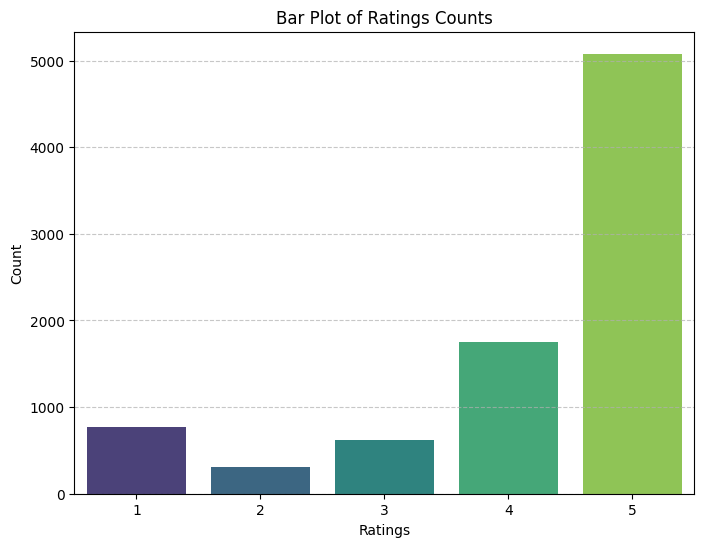

In [ ]:
# Plot bar plot of ratings counts
plt.figure(figsize=(8, 6))
sns.countplot(data=drb, x='Ratings', palette='viridis')
plt.title("Bar Plot of Ratings Counts")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines on y-axis
plt.show()

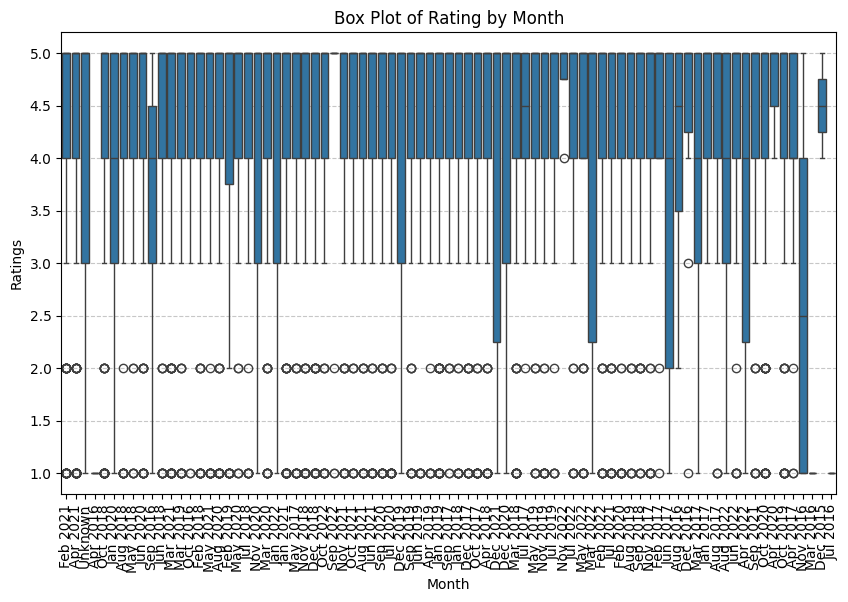

In [ ]:
# Plot box plot of rating by month
plt.figure(figsize=(10, 6))
sns.boxplot(data=drb, x='Month', y='Ratings')
plt.title("Box Plot of Rating by Month")
plt.xlabel("Month")
plt.ylabel("Ratings")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

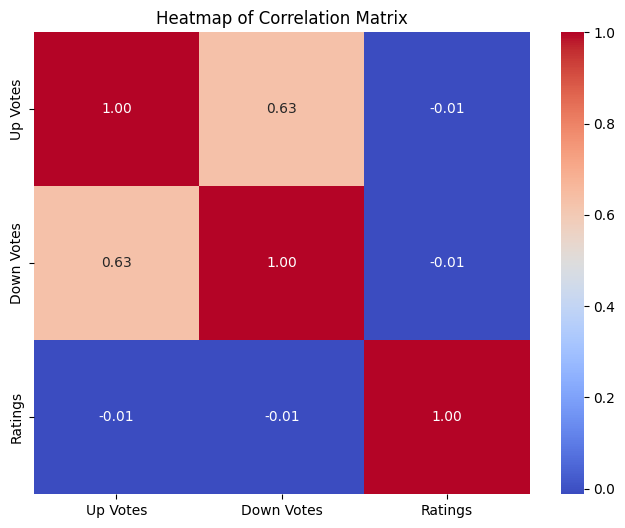

In [ ]:
# Compute correlation matrix
correlation_matrix = drb[['Up Votes', 'Down Votes', 'Ratings']].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Correlation Matrix")
plt.show()


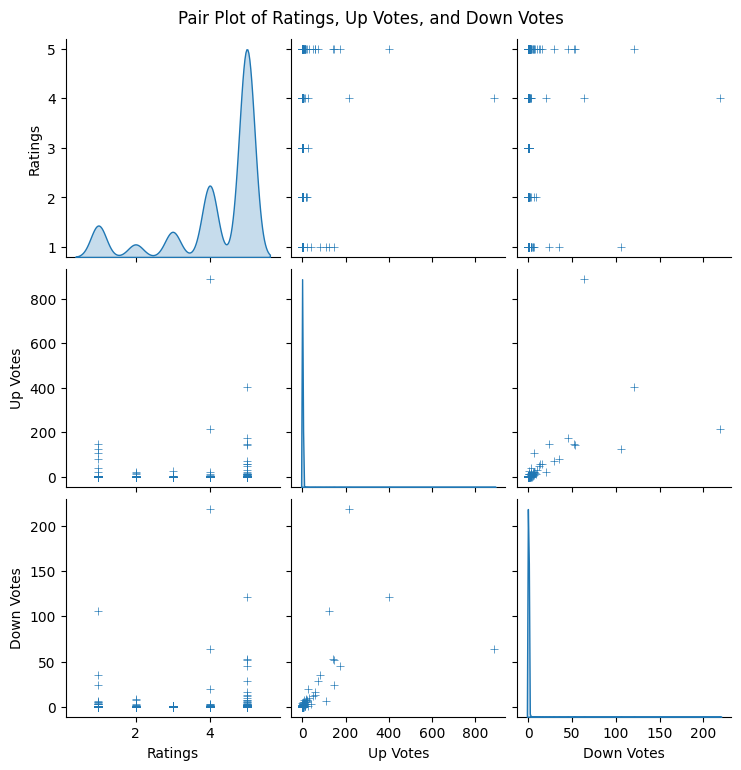

In [ ]:
# Select columns for pair plot
pairplot_data = drb[['Ratings', 'Up Votes', 'Down Votes']]

# Create pair plot
sns.pairplot(pairplot_data, diag_kind='kde', markers='+')
plt.suptitle("Pair Plot of Ratings, Up Votes, and Down Votes", y=1.02)
plt.show()


In [ ]:
# Convert review text to lowercase
drb['Review text'] = drb['Review text'].str.lower()
# Concatenate all review texts into a single string
text = ' '.join(drb['Review text'])

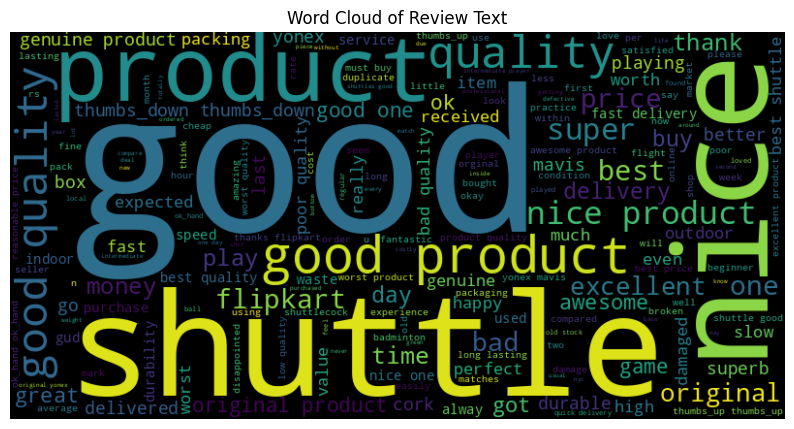

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Review Text')
plt.axis('off')
plt.show()

###Interactive visualizations

In [ ]:
fig = px.histogram(drb, x='Ratings', title='Interactive Histogram of Ratings')
fig.update_layout(xaxis_title='Ratings', yaxis_title='Count')
fig.show()


In [ ]:
fig = px.scatter(drb, x='Ratings', y='Up Votes', title='Interactive Scatter Plot of Ratings vs. Up Votes')
fig.update_layout(xaxis_title='Ratings', yaxis_title='Up Votes')
fig.show()

In [ ]:
fig = px.scatter_3d(drb, x='Ratings', y='Up Votes', z='Down Votes', title='Interactive 3D Scatter Plot of Ratings vs. Up Votes vs. Down Votes')
fig.update_layout(scene=dict(xaxis_title='Ratings', yaxis_title='Up Votes', zaxis_title='Down Votes'))
fig.show()

## Data Preparation
1. Identifying the inputs (X) and output (y)


In [ ]:
y = drb['Sentiment']
X = drb[['Review text','Review Title']]

2. Spliting into train and test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
X_train.head()

,Review text,Review Title
6289,nice. shuttle,Good choice
549,"product are good only, but we received the sto...",Nice
4707,"excellent service, got in one day even at remo...",Waste of money!
764,good but high price...,Good quality product
6861,there are 2 damaged shuttles out of 6..not sat...,Awesome


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6814, 2) (6814,)
(1704, 2) (1704,)


##Data Preparation - Text Preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stemmer = PorterStemmer()

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(raw_text, flag):
  sentence = re.sub("[^a-zA-Z]"," ", raw_text)
  sentence = sentence.lower()
  tokens = sentence.split()
  stop_words = set(stopwords.words("english"))
  stop_words.discard("not")
  clean_tokens = [t for t in tokens if not t in stop_words]

  if(flag == 'stem'):
    clean_tokens = [stemmer.stem(word) for word in clean_tokens]
  else:
    clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]
  cleaned_text = " ".join(clean_tokens)
  return pd.Series([cleaned_text, len(clean_tokens)], index=['Cleaned Text', 'Token Count'])
  return str(cleaned_text)

In [ ]:
X_train.head(100)

,Review text,Review Title
6289,nice. shuttle,Good choice
549,"product are good only, but we received the sto...",Nice
4707,"excellent service, got in one day even at remo...",Waste of money!
764,good but high price...,Good quality product
6861,there are 2 damaged shuttles out of 6..not sat...,Awesome
...,...,...
8318,nice one,Terrific
3279,coke is not as per original...cannt play more ...,Awesome
4567,i felling very good when i play.,Very poor
7277,great product,Very poor


In [ ]:
%%timeit
X_train['Review text'].apply(lambda x: preprocess(x, 'stem'))

4.9 s ± 1.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
X_train['Review Title'].apply(lambda x: preprocess(x, 'stem'))

4.02 s ± 448 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm, tqdm_notebook

In [ ]:
tqdm.pandas()

In [ ]:
X_train[['Review text', 'Review Title']].dtypes

Review text     object
Review Title    object
dtype: object

In [ ]:
# Apply preprocess function to both 'Review text' and 'Review Title' columns simultaneously
temp_drb = X_train[['Review text', 'Review Title']].progress_apply(lambda x: preprocess(x['Review text'], 'stem')  + preprocess(x['Review Title'], 'stem'), axis=1)

# Display the first few rows of the resulting DataFrame
temp_drb.head()


100%|██████████| 6814/6814 [00:14<00:00, 482.86it/s]


,Cleaned Text,Token Count
6289,nice shuttlgood choic,4
549,product good receiv stock month befor manufact...,8
4707,excel servic got one day even remot locat like...,12
764,good high pricegood qualiti product,6
6861,damag shuttl not satisfiawesom,5


In [ ]:
temp_drb.columns = ['clean_text_stem', 'text_length_stem']
temp_drb.head()

,clean_text_stem,text_length_stem
6289,nice shuttlgood choic,4
549,product good receiv stock month befor manufact...,8
4707,excel servic got one day even remot locat like...,12
764,good high pricegood qualiti product,6
6861,damag shuttl not satisfiawesom,5


In [ ]:
X_train = pd.concat([X_train, temp_drb], axis=1)
X_train.head()

,Review text,Review Title,clean_text_stem,text_length_stem
6289,nice. shuttle,Good choice,nice shuttlgood choic,4
549,"product are good only, but we received the sto...",Nice,product good receiv stock month befor manufact...,8
4707,"excellent service, got in one day even at remo...",Waste of money!,excel servic got one day even remot locat like...,12
764,good but high price...,Good quality product,good high pricegood qualiti product,6
6861,there are 2 damaged shuttles out of 6..not sat...,Awesome,damag shuttl not satisfiawesom,5


In [ ]:
temp_drb = X_train.progress_apply(lambda row: preprocess(row['Review text'], 'lemma')  +  preprocess(row['Review Title'], 'lemma'), axis=1)
temp_drb.head()


100%|██████████| 6814/6814 [00:20<00:00, 328.20it/s]


,Cleaned Text,Token Count
6289,nice shuttlegood choice,4
549,product good received stock month befor manufa...,8
4707,excellent service got one day even remote loca...,12
764,good high pricegood quality product,6
6861,damaged shuttle not satisfiedawesome,5


In [ ]:
temp_drb.columns = ['clean_text_lemma', 'text_length_lemma']
temp_drb.head()

,clean_text_lemma,text_length_lemma
6289,nice shuttlegood choice,4
549,product good received stock month befor manufa...,8
4707,excellent service got one day even remote loca...,12
764,good high pricegood quality product,6
6861,damaged shuttle not satisfiedawesome,5


In [ ]:
X_train = pd.concat([X_train, temp_drb], axis=1)
X_train.head()

,Review text,Review Title,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma
6289,nice. shuttle,Good choice,nice shuttlgood choic,4,nice shuttlegood choice,4
549,"product are good only, but we received the sto...",Nice,product good receiv stock month befor manufact...,8,product good received stock month befor manufa...,8
4707,"excellent service, got in one day even at remo...",Waste of money!,excel servic got one day even remot locat like...,12,excellent service got one day even remote loca...,12
764,good but high price...,Good quality product,good high pricegood qualiti product,6,good high pricegood quality product,6
6861,there are 2 damaged shuttles out of 6..not sat...,Awesome,damag shuttl not satisfiawesom,5,damaged shuttle not satisfiedawesome,5


In [ ]:
X_train.head(100)

,Review text,Review Title,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma
6289,nice. shuttle,Good choice,nice shuttlgood choic,4,nice shuttlegood choice,4
549,"product are good only, but we received the sto...",Nice,product good receiv stock month befor manufact...,8,product good received stock month befor manufa...,8
4707,"excellent service, got in one day even at remo...",Waste of money!,excel servic got one day even remot locat like...,12,excellent service got one day even remote loca...,12
764,good but high price...,Good quality product,good high pricegood qualiti product,6,good high pricegood quality product,6
6861,there are 2 damaged shuttles out of 6..not sat...,Awesome,damag shuttl not satisfiawesom,5,damaged shuttle not satisfiedawesome,5
...,...,...,...,...,...,...
8318,nice one,Terrific,nice oneterrif,3,nice oneterrific,3
3279,coke is not as per original...cannt play more ...,Awesome,coke not per origin cannt play day qualiti not...,11,coke not per original cannt play day quality n...,11
4567,i felling very good when i play.,Very poor,fell good playpoor,4,felling good playpoor,4
7277,great product,Very poor,great productpoor,3,great productpoor,3


##Feature Engineering

In [ ]:

# Function to calculate text length
def calculate_text_length(text):
    return len(word_tokenize(text))

# Function to count words
def count_words(text):
    return len(text.split())

# Function to check presence of keywords
def check_keyword_presence(text, keywords):
    text_lower = text.lower()
    return int(any(keyword.lower() in text_lower for keyword in keywords))

positive_keywords = ['good', 'nice', 'best', 'super', 'awesome', 'great', 'happy']
negative_keywords = ['bad', 'poor', 'awful', 'terrible', 'horrible', 'slow', 'worst']


# Apply feature engineering functions to create new features
drb['Text Length'] = drb['Review text'].apply(calculate_text_length)
drb['Word Count'] = drb['Review text'].apply(count_words)
drb['Contains_Positive_Word'] = drb['Review text'].apply(lambda x: check_keyword_presence(x, positive_keywords))
drb['Contains_Negative_Word'] = drb['Review text'].apply(lambda x: check_keyword_presence(x, negative_keywords))

# Display the DataFrame with new features
print(drb.head())


            Reviewer Name               Review Title  \
0            Kamal Suresh               Nice product   
1       Flipkart Customer     Don't waste your money   
2  A. S. Raja Srinivasan   Did not meet expectations   
3     Suresh Narayanasamy                       Fair   
4               ASHIK P A                Over priced   

               Place of Review  Up Votes  Down Votes     Month  \
0   Certified Buyer, Chirakkal     889.0        64.0  Feb 2021   
1   Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
2  Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
3     Certified Buyer, Chennai      25.0         1.0   Unknown   
4                      Unknown     147.0        24.0  Apr 2016   

                                         Review text  Ratings Emojis  \
0  nice product, good quality, but price is now r...        4     []   
1  they didn't supplied yonex mavis 350. outside ...        1     []   
2  worst product. damaged shuttlecocks packed in .

##Creating the WordCloud for sentiment analysis

In [ ]:
y_train

6289    positive
549     negative
4707    positive
764     positive
6861    negative
          ...   
5734    positive
5191    positive
5390    positive
860     positive
7270    negative
Name: Sentiment, Length: 6814, dtype: object

In [ ]:
y_test

7497    positive
5257    positive
2571    positive
1084    positive
856     positive
          ...   
7036    positive
7199    positive
4581    positive
4925    negative
3617    positive
Name: Sentiment, Length: 1704, dtype: object

####Positive ratings

In [ ]:
pos_df = X_train[y_train == 'positive']

In [ ]:
pos_df.head()

,Review text,Review Title,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma
6289,nice. shuttle,Good choice,nice shuttlgood choic,4,nice shuttlegood choice,4
4707,"excellent service, got in one day even at remo...",Waste of money!,excel servic got one day even remot locat like...,12,excellent service got one day even remote loca...,12
764,good but high price...,Good quality product,good high pricegood qualiti product,6,good high pricegood quality product,6
5849,good one. i recommend this shuttlecock for the...,Just wow!,good one recommend shuttlecock beginnwow,6,good one recommend shuttlecock beginnerwow,6
5549,good product,Just okay,good productokay,3,good productokay,3


In [ ]:
words = ' '.join(pos_df['clean_text_lemma'])
print(words[:100])

nice shuttlegood choice excellent service got one day even remote location like gangtokwaste money g


In [ ]:
pos_df = X_train.loc[y_train=='positive', :]

words = ' '.join(pos_df['clean_text_lemma'])

cleaned_word = " ".join([word for word in words.split()
                        if 'subject' not in word])

In [ ]:
pos_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

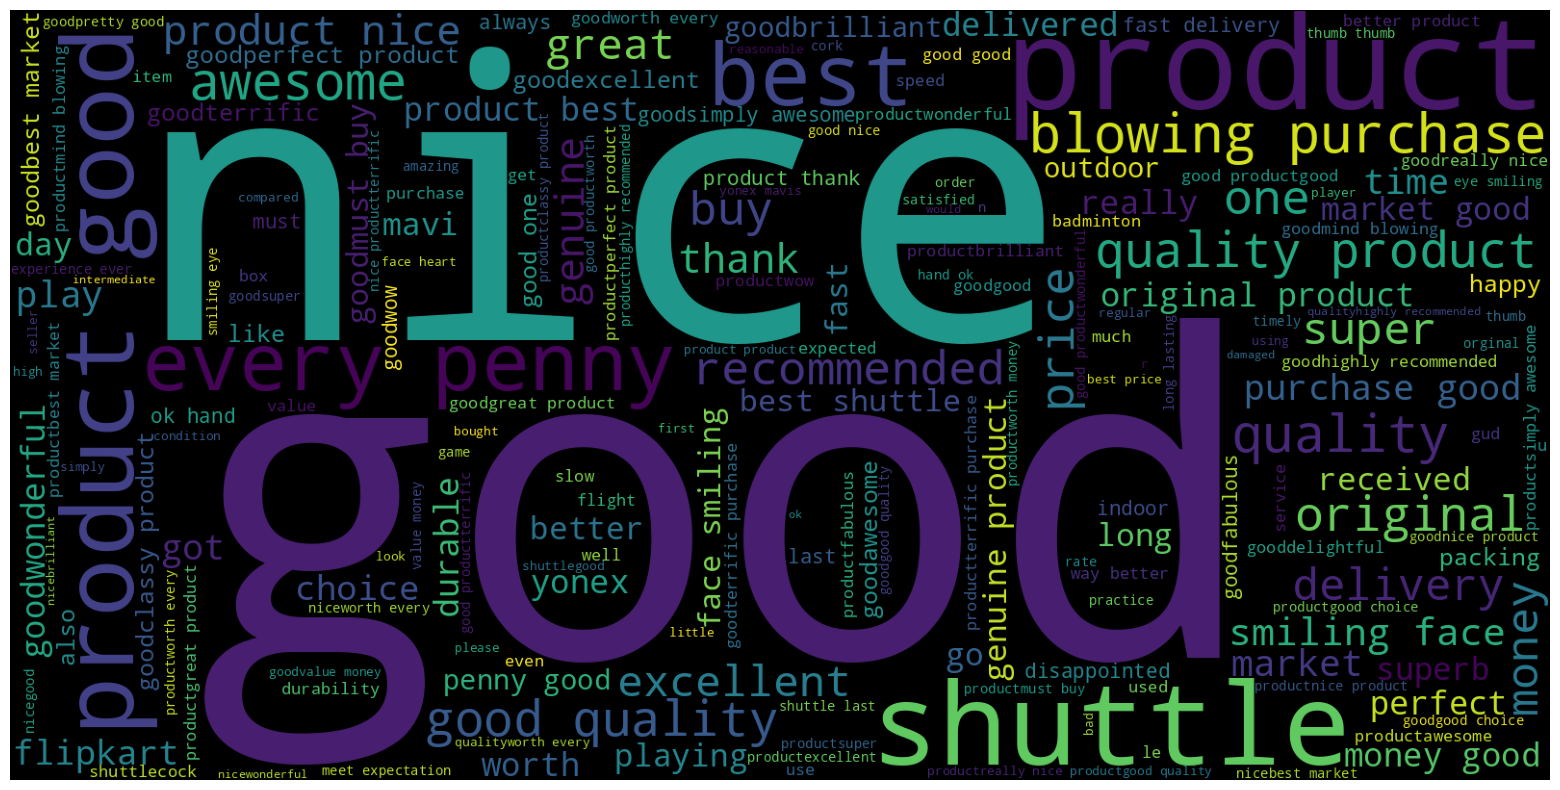

In [ ]:
plt.figure(1,figsize=(20,10))
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()

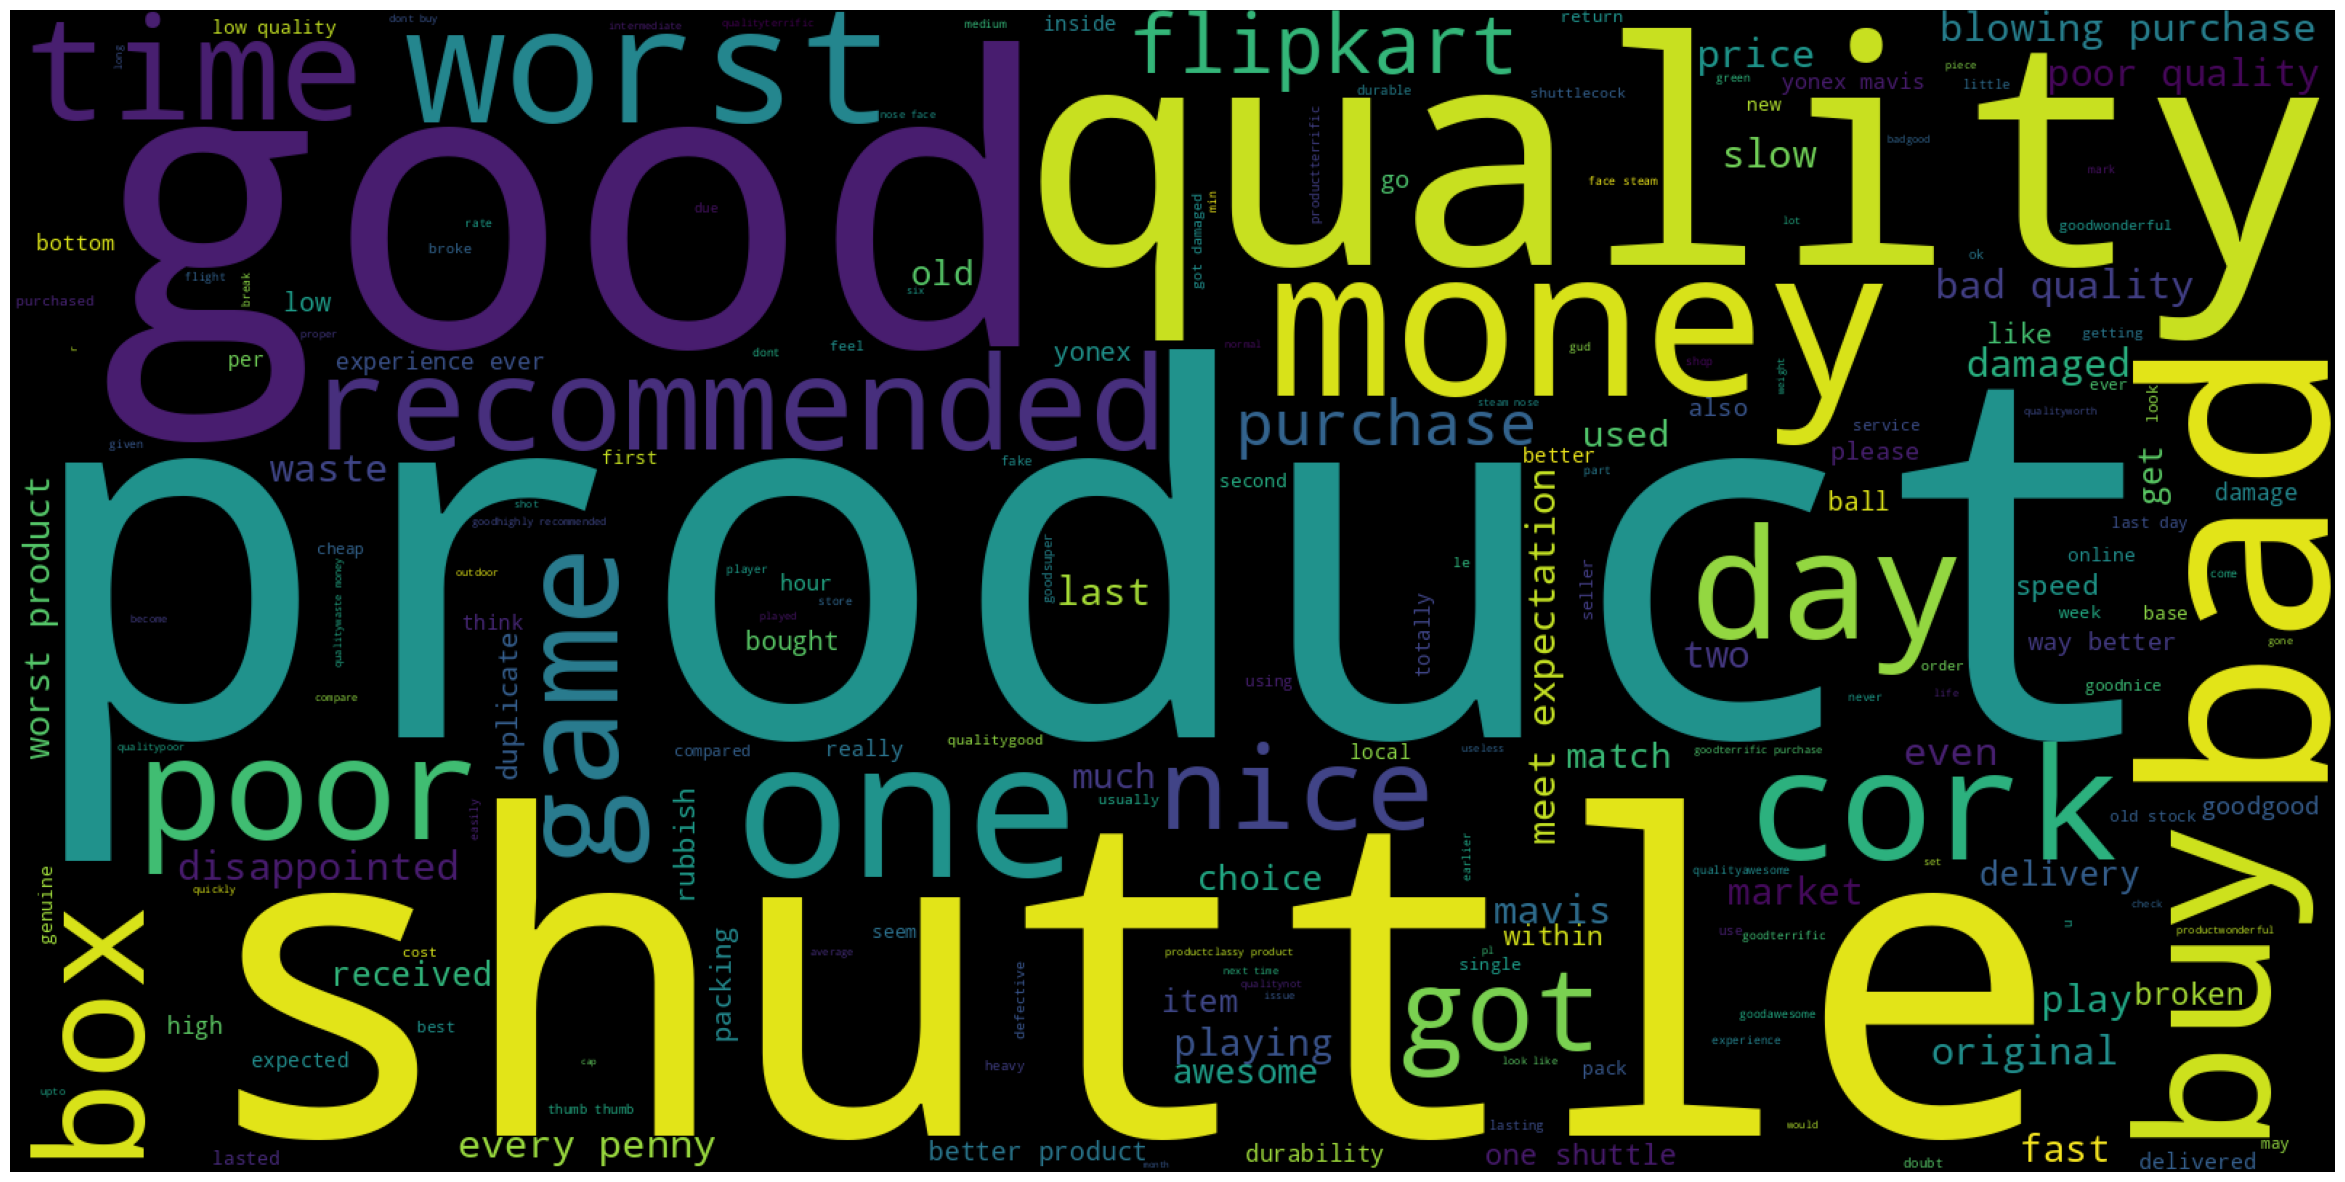

In [ ]:
neg_df = X_train.loc[y_train=='negative', :]

words = ' '.join(neg_df['clean_text_lemma'])

cleaned_word = " ".join([word for word in words.split()
                        if 'subject' not in word])
neg_wordcloud = WordCloud(stopwords=stopwords.words("english"),
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)
plt.figure(1,figsize=(30,20))
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

#Converting Text to Numerical Vectors - (BOW and TFIDF Approach)

##1. Bow Representation

In [ ]:
X_train.head()

,Review text,Review Title
6289,nice. shuttle,Good choice
549,"product are good only, but we received the sto...",Nice
4707,"excellent service, got in one day even at remo...",Waste of money!
764,good but high price...,Good quality product
6861,there are 2 damaged shuttles out of 6..not sat...,Awesome


In [ ]:
vocab = CountVectorizer()
X_train_bow = vocab.fit_transform(X_train['clean_text_lemma'])

In [ ]:
print("total unique words:", len(vocab.vocabulary_))
print("type of train features:", type(X_train_bow))
print("shape of input data", X_train_bow.shape)

total unique words: 4773
type of train features: <class 'scipy.sparse._csr.csr_matrix'>
shape of input data (6814, 4773)


In [ ]:
print(X_train_bow.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
from sys import getsizeof
print(type(X_train_bow))
print(getsizeof(X_train_bow, "Bytes"))

<class 'scipy.sparse._csr.csr_matrix'>
48


In [ ]:
print(type(X_train_bow.toarray()))
print(getsizeof(X_train_bow.toarray()), "Bytes")

<class 'numpy.ndarray'>
260185904 Bytes


In [ ]:
X_train_bow = vocab.transform(X_train['clean_text_lemma'])

In [ ]:
X_train_bow_df = pd.DataFrame.sparse.from_spmatrix(X_train_bow)

In [ ]:
X_train_bow_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4763,4764,4765,4766,4767,4768,4769,4770,4771,4772
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###Preprocessing the Test Data

In [ ]:
X_test.head()

,Review text,Review Title
7497,fast deliveryoriginal productreasonable price,Best in the market!
5257,working well in out door game,Terrific
2571,its value for money and most importantly it's ...,Delightful
1084,horrible,Just wow!
856,goog,Super!


In [ ]:
%%timeit
X_test['Review text'].apply(lambda x: preprocess(x, 'stem'))

1.02 s ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
X_test['Review Title'].apply(lambda x: preprocess(x, 'stem'))

1.12 s ± 210 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Apply preprocess function to both 'Review text' and 'Review Title' columns simultaneously
temp_dr = X_test[['Review text', 'Review Title']].progress_apply(lambda x: preprocess(x['Review text'], 'stem') + preprocess(x['Review Title'], 'stem'), axis=1)

# Display the first few rows of the resulting DataFrame
temp_dr.head()

100%|██████████| 1704/1704 [00:02<00:00, 709.36it/s]


,Cleaned Text,Token Count
7497,fast deliveryorigin productreason pricebest ma...,6
5257,work well door gameterrif,5
2571,valu money importantli origindelight,5
1084,horriblwow,2
856,googsuper,2


In [ ]:
temp_dr.columns = ['clean_text_stem', 'text_length_stem']
temp_dr.head()

,clean_text_stem,text_length_stem
7497,fast deliveryorigin productreason pricebest ma...,6
5257,work well door gameterrif,5
2571,valu money importantli origindelight,5
1084,horriblwow,2
856,googsuper,2


In [ ]:
X_test = pd.concat([X_test, temp_dr], axis=1)
X_test.head()

,Review text,Review Title,clean_text_stem,text_length_stem
7497,fast deliveryoriginal productreasonable price,Best in the market!,fast deliveryorigin productreason pricebest ma...,6
5257,working well in out door game,Terrific,work well door gameterrif,5
2571,its value for money and most importantly it's ...,Delightful,valu money importantli origindelight,5
1084,horrible,Just wow!,horriblwow,2
856,goog,Super!,googsuper,2


In [ ]:
temp_dr = X_test.progress_apply(lambda row: preprocess(row['Review text'], 'lemma') + preprocess(row['Review Title'], 'lemma'), axis=1)
temp_dr.head()


100%|██████████| 1704/1704 [00:02<00:00, 778.68it/s]


,Cleaned Text,Token Count
7497,fast deliveryoriginal productreasonable priceb...,6
5257,working well door gameterrific,5
2571,value money importantly originaldelightful,5
1084,horriblewow,2
856,googsuper,2


In [ ]:

temp_dr.columns = ['clean_text_lemma', 'text_length_lemma']
temp_dr.head()

,clean_text_lemma,text_length_lemma
7497,fast deliveryoriginal productreasonable priceb...,6
5257,working well door gameterrific,5
2571,value money importantly originaldelightful,5
1084,horriblewow,2
856,googsuper,2


In [ ]:
X_test = pd.concat([X_test, temp_dr], axis=1)
X_test.head()

,Review text,Review Title,clean_text_stem,text_length_stem,clean_text_lemma,text_length_lemma
7497,fast deliveryoriginal productreasonable price,Best in the market!,fast deliveryorigin productreason pricebest ma...,6,fast deliveryoriginal productreasonable priceb...,6
5257,working well in out door game,Terrific,work well door gameterrif,5,working well door gameterrific,5
2571,its value for money and most importantly it's ...,Delightful,valu money importantli origindelight,5,value money importantly originaldelightful,5
1084,horrible,Just wow!,horriblwow,2,horriblewow,2
856,goog,Super!,googsuper,2,googsuper,2


##BOW

In [ ]:
X_test_bow = vocab.transform(X_test['clean_text_lemma'])

In [ ]:
X_test_bow_df = pd.DataFrame.sparse.from_spmatrix(X_test_bow)

In [ ]:
X_test_bow_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,4763,4764,4765,4766,4767,4768,4769,4770,4771,4772
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_bow, y_train)

LogisticRegression()

In [ ]:
y_train_pred = classifier.predict(X_train_bow)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9217786909304373
              precision    recall  f1-score   support

    negative       0.93      0.66      0.77      1367
    positive       0.92      0.99      0.95      5447

    accuracy                           0.92      6814
   macro avg       0.93      0.82      0.86      6814
weighted avg       0.92      0.92      0.92      6814



In [ ]:
y_test_pred = classifier.predict(X_test_bow_df)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

0.8779342723004695
              precision    recall  f1-score   support

    negative       0.82      0.46      0.59       325
    positive       0.88      0.98      0.93      1379

    accuracy                           0.88      1704
   macro avg       0.85      0.72      0.76      1704
weighted avg       0.87      0.88      0.86      1704



###Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train_bow, y_train)

DecisionTreeClassifier()

In [ ]:
y_train_pred = classifier.predict(X_train_bow)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9765189316113884
              precision    recall  f1-score   support

    negative       0.98      0.90      0.94      1367
    positive       0.98      0.99      0.99      5447

    accuracy                           0.98      6814
   macro avg       0.98      0.95      0.96      6814
weighted avg       0.98      0.98      0.98      6814



In [ ]:
y_test_pred = classifier.predict(X_test_bow_df)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.8667840375586855
              precision    recall  f1-score   support

    negative       0.70      0.53      0.60       325
    positive       0.89      0.95      0.92      1379

    accuracy                           0.87      1704
   macro avg       0.80      0.74      0.76      1704
weighted avg       0.86      0.87      0.86      1704



###Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train_bow, y_train)

RandomForestClassifier()

In [ ]:
y_train_pred = classifier.predict(X_train_bow)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9765189316113884
              precision    recall  f1-score   support

    negative       0.98      0.90      0.94      1367
    positive       0.98      1.00      0.99      5447

    accuracy                           0.98      6814
   macro avg       0.98      0.95      0.96      6814
weighted avg       0.98      0.98      0.98      6814



In [ ]:
y_test_pred = classifier.predict(X_test_bow_df)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.8779342723004695
              precision    recall  f1-score   support

    negative       0.76      0.52      0.62       325
    positive       0.89      0.96      0.93      1379

    accuracy                           0.88      1704
   macro avg       0.83      0.74      0.77      1704
weighted avg       0.87      0.88      0.87      1704



###KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize KNN classifier
classifier = KNeighborsClassifier()

# Train the classifier
classifier.fit(X_train_bow, y_train)

KNeighborsClassifier()

In [ ]:
y_train_pred = classifier.predict(X_train_bow)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.8818608746697975
              precision    recall  f1-score   support

    negative       0.87      0.48      0.62      1367
    positive       0.88      0.98      0.93      5447

    accuracy                           0.88      6814
   macro avg       0.88      0.73      0.77      6814
weighted avg       0.88      0.88      0.87      6814



In [ ]:
# Predict on test data
y_test_pred = classifier.predict(X_test_bow)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))



0.8591549295774648
              precision    recall  f1-score   support

    negative       0.80      0.35      0.49       325
    positive       0.86      0.98      0.92      1379

    accuracy                           0.86      1704
   macro avg       0.83      0.66      0.70      1704
weighted avg       0.85      0.86      0.84      1704



###Naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize Naive Bayes classifier
classifier = MultinomialNB()

# Train the classifier
classifier.fit(X_train_bow, y_train)


MultinomialNB()

In [ ]:
y_train_pred = classifier.predict(X_train_bow)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9172292339301438
              precision    recall  f1-score   support

    negative       0.90      0.66      0.76      1367
    positive       0.92      0.98      0.95      5447

    accuracy                           0.92      6814
   macro avg       0.91      0.82      0.86      6814
weighted avg       0.92      0.92      0.91      6814



In [ ]:
y_test_pred = classifier.predict(X_test_bow)

In [ ]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_test_pred))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_test_pred))

Naive Bayes Accuracy: 0.880868544600939
Naive Bayes Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.50      0.61       325
    positive       0.89      0.97      0.93      1379

    accuracy                           0.88      1704
   macro avg       0.85      0.73      0.77      1704
weighted avg       0.87      0.88      0.87      1704



###SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize SVM classifier
classifier = SVC()

# Train the classifier
classifier.fit(X_train_bow, y_train)


SVC()

In [ ]:
y_train_pred = classifier.predict(X_train_bow)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9316113883181685
              precision    recall  f1-score   support

    negative       0.95      0.69      0.80      1367
    positive       0.93      0.99      0.96      5447

    accuracy                           0.93      6814
   macro avg       0.94      0.84      0.88      6814
weighted avg       0.93      0.93      0.93      6814



In [ ]:
y_test_pred = classifier.predict(X_test_bow)

In [ ]:
print("Support Vector Machine (SVM) Accuracy:", accuracy_score(y_test, y_test_pred))
print("Support Vector Machine (SVM) Classification Report:\n", classification_report(y_test, y_test_pred))

Support Vector Machine (SVM) Accuracy: 0.8697183098591549
Support Vector Machine (SVM) Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.40      0.54       325
    positive       0.87      0.98      0.92      1379

    accuracy                           0.87      1704
   macro avg       0.85      0.69      0.73      1704
weighted avg       0.86      0.87      0.85      1704



###Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Gradient Boosting classifier
classifier = GradientBoostingClassifier()

# Train the classifier
classifier.fit(X_train_bow, y_train)

GradientBoostingClassifier()

In [ ]:
y_train_pred = classifier.predict(X_train_bow)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.893014382154388
              precision    recall  f1-score   support

    negative       0.88      0.54      0.67      1367
    positive       0.89      0.98      0.94      5447

    accuracy                           0.89      6814
   macro avg       0.89      0.76      0.80      6814
weighted avg       0.89      0.89      0.88      6814



In [ ]:
y_test_pred = classifier.predict(X_test_bow_df)

In [ ]:
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, y_test_pred))
print("Gradient Boosting Classifier Classification Report:\n", classification_report(y_test, y_test_pred))

Gradient Boosting Classifier Accuracy: 0.8726525821596244
Gradient Boosting Classifier Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.44      0.57       325
    positive       0.88      0.97      0.93      1379

    accuracy                           0.87      1704
   macro avg       0.84      0.71      0.75      1704
weighted avg       0.87      0.87      0.86      1704



##TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train['clean_text_lemma'])

TfidfVectorizer()

In [ ]:
X_train_tfidf = tfidf_vectorizer.transform(X_train['clean_text_lemma'])

In [ ]:
X_test_tfidf = tfidf_vectorizer.transform(X_test['clean_text_lemma'])

In [ ]:
print("Total unique words:", len(tfidf_vectorizer.vocabulary_))

# Print type and shape of training data
print("Type of train features:", type(X_train_tfidf))
print("Shape of training data:", X_train_tfidf.shape)


Total unique words: 4773
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of training data: (6814, 4773)


In [ ]:
print("Type of test features:", type(X_test_tfidf))
print("Shape of testing data:", X_test_tfidf.shape)

Type of test features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of testing data: (1704, 4773)


###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_tfidf, y_train)

LogisticRegression()

In [ ]:
y_test_pred = classifier.predict(X_test_tfidf)

In [ ]:
y_train_pred = classifier.predict(X_train_tfidf)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9003522160258292
              precision    recall  f1-score   support

    negative       0.92      0.55      0.69      1367
    positive       0.90      0.99      0.94      5447

    accuracy                           0.90      6814
   macro avg       0.91      0.77      0.82      6814
weighted avg       0.90      0.90      0.89      6814



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.8814553990610329
              precision    recall  f1-score   support

    negative       0.84      0.46      0.60       325
    positive       0.89      0.98      0.93      1379

    accuracy                           0.88      1704
   macro avg       0.86      0.72      0.76      1704
weighted avg       0.88      0.88      0.87      1704



###Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train_tfidf, y_train)

DecisionTreeClassifier()

In [ ]:
y_train_pred = classifier.predict(X_train_tfidf)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9765189316113884
              precision    recall  f1-score   support

    negative       0.98      0.90      0.94      1367
    positive       0.98      0.99      0.99      5447

    accuracy                           0.98      6814
   macro avg       0.98      0.95      0.96      6814
weighted avg       0.98      0.98      0.98      6814



In [ ]:
y_test_pred = classifier.predict(X_test_tfidf)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.857981220657277
              precision    recall  f1-score   support

    negative       0.68      0.48      0.56       325
    positive       0.89      0.95      0.92      1379

    accuracy                           0.86      1704
   macro avg       0.78      0.71      0.74      1704
weighted avg       0.85      0.86      0.85      1704



###Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [ ]:
y_train_pred = classifier.predict(X_train_tfidf)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9765189316113884
              precision    recall  f1-score   support

    negative       0.98      0.90      0.94      1367
    positive       0.97      1.00      0.99      5447

    accuracy                           0.98      6814
   macro avg       0.98      0.95      0.96      6814
weighted avg       0.98      0.98      0.98      6814



In [ ]:
y_test_pred = classifier.predict(X_test_tfidf)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.8791079812206573
              precision    recall  f1-score   support

    negative       0.78      0.51      0.62       325
    positive       0.89      0.97      0.93      1379

    accuracy                           0.88      1704
   macro avg       0.84      0.74      0.77      1704
weighted avg       0.87      0.88      0.87      1704



###knn

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
classifier = KNeighborsClassifier()
classifier.fit(X_train_tfidf, y_train)

KNeighborsClassifier()

In [ ]:
y_train_pred = classifier.predict(X_train_tfidf)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.882301144702084
              precision    recall  f1-score   support

    negative       0.85      0.50      0.63      1367
    positive       0.89      0.98      0.93      5447

    accuracy                           0.88      6814
   macro avg       0.87      0.74      0.78      6814
weighted avg       0.88      0.88      0.87      6814



In [ ]:
y_test_pred = classifier.predict(X_test_tfidf)

In [ ]:
print("K-Nearest Neighbors (KNN) Accuracy:", accuracy_score(y_test, y_test_pred))
print("K-Nearest Neighbors (KNN) Classification Report:\n", classification_report(y_test, y_test_pred))

K-Nearest Neighbors (KNN) Accuracy: 0.8474178403755869
K-Nearest Neighbors (KNN) Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.35      0.47       325
    positive       0.86      0.96      0.91      1379

    accuracy                           0.85      1704
   macro avg       0.78      0.66      0.69      1704
weighted avg       0.83      0.85      0.83      1704



###NB

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

MultinomialNB()

In [ ]:
y_train_pred = classifier.predict(X_train_tfidf)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9097446433812738
              precision    recall  f1-score   support

    negative       0.96      0.57      0.72      1367
    positive       0.90      0.99      0.95      5447

    accuracy                           0.91      6814
   macro avg       0.93      0.78      0.83      6814
weighted avg       0.91      0.91      0.90      6814



In [ ]:
y_test_pred = classifier.predict(X_test_tfidf)

In [ ]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_test_pred))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_test_pred))

Naive Bayes Accuracy: 0.8568075117370892
Naive Bayes Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.33      0.47       325
    positive       0.86      0.98      0.92      1379

    accuracy                           0.86      1704
   macro avg       0.83      0.66      0.69      1704
weighted avg       0.85      0.86      0.83      1704



###SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
classifier = SVC()
classifier.fit(X_train_tfidf, y_train)

SVC()

In [ ]:
y_train_pred = classifier.predict(X_train_tfidf)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9543586733196361
              precision    recall  f1-score   support

    negative       0.96      0.80      0.88      1367
    positive       0.95      0.99      0.97      5447

    accuracy                           0.95      6814
   macro avg       0.96      0.90      0.92      6814
weighted avg       0.95      0.95      0.95      6814



In [ ]:
y_test_pred = classifier.predict(X_test_tfidf)

In [ ]:
print("Support Vector Machine (SVM) Accuracy:", accuracy_score(y_test, y_test_pred))
print("Support Vector Machine (SVM) Classification Report:\n", classification_report(y_test, y_test_pred))

Support Vector Machine (SVM) Accuracy: 0.8832159624413145
Support Vector Machine (SVM) Classification Report:
               precision    recall  f1-score   support

    negative       0.83      0.49      0.61       325
    positive       0.89      0.98      0.93      1379

    accuracy                           0.88      1704
   macro avg       0.86      0.73      0.77      1704
weighted avg       0.88      0.88      0.87      1704



###Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
classifier = GradientBoostingClassifier()
classifier.fit(X_train_tfidf, y_train)

GradientBoostingClassifier()

In [ ]:
y_train_pred = classifier.predict(X_train_tfidf)

from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.8962430290578222
              precision    recall  f1-score   support

    negative       0.90      0.54      0.68      1367
    positive       0.90      0.98      0.94      5447

    accuracy                           0.90      6814
   macro avg       0.90      0.76      0.81      6814
weighted avg       0.90      0.90      0.89      6814



In [ ]:
y_test_pred = classifier.predict(X_test_tfidf)

In [ ]:
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

0.8720657276995305
              precision    recall  f1-score   support

    negative       0.81      0.43      0.56       325
    positive       0.88      0.98      0.93      1379

    accuracy                           0.87      1704
   macro avg       0.84      0.70      0.74      1704
weighted avg       0.87      0.87      0.86      1704



##Pipeline

####Decision tree


1. Bow

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define pipeline for Decision Tree
pipe_2 = Pipeline([
    ('scaler', StandardScaler()),  # Not necessary for Decision Trees, but keeping it for consistency
    ('classifier', DecisionTreeClassifier())
])

# Define parameter grid for Decision Tree
MAX_DEPTH = [i for i in range(3, 21, 2)]
MIN_SAMPLES_SPLIT = [2, 5, 10]
CRITERION = ['gini', 'entropy']

parameter_grid_2 = [{
    'scaler': [StandardScaler(), MaxAbsScaler()],
    'classifier__max_depth': MAX_DEPTH,
    'classifier__min_samples_split': MIN_SAMPLES_SPLIT,
    'classifier__criterion': CRITERION
}]

# Grid Search for Decision Tree
clf_tree = GridSearchCV(
    estimator=pipe_2,
    param_grid=parameter_grid_2,
    scoring='accuracy',
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf_tree.fit(X_train_bow, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
CPU times: user 21.8 s, sys: 77.8 ms, total: 21.9 s
Wall time: 22.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid=[{'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [3, 5, 7, 9, 11, 13, 15, 17,
                                                    19],
                          'classifier__min_samples_split': [2, 5, 10],
                          'scaler': [StandardScaler(), MaxAbsScaler()]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
print("Best estimator found on train set")
print(clf_tree.best_estimator_)
print()

print('Score on Train Data: ', clf_tree.score(X_train_bow, y_train))


Best estimator found on train set
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier', DecisionTreeClassifier(max_depth=9))])

Score on Train Data:  0.8971235691223951


In [ ]:
print("Best estimator found on train set")
print(clf_tree.best_estimator_)
print()

print('Score on Test Data: ', clf_tree.score(X_test_bow, y_test))


Best estimator found on train set
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier', DecisionTreeClassifier(max_depth=9))])

Score on Test Data:  0.8720657276995305


In [ ]:
import joblib
import os

joblib.dump(classifier,'DecisionTreeClassifier.pkl')

['DecisionTreeClassifier.pkl']

2. tfidf

In [ ]:
# Define pipeline for Decision Tree
pipe_t = Pipeline([
    ('scaler', StandardScaler()),  # Not necessary for Decision Trees, but keeping it for consistency
    ('classifier', DecisionTreeClassifier())
])

# Define parameter grid for Decision Tree
MAX_DEPTH = [i for i in range(3, 21, 2)]
MIN_SAMPLES_SPLIT = [2, 5, 10]
CRITERION = ['gini', 'entropy']

parameter_grid_2 = [{
    'scaler': [StandardScaler(), MaxAbsScaler()],
    'classifier__max_depth': MAX_DEPTH,
    'classifier__min_samples_split': MIN_SAMPLES_SPLIT,
    'classifier__criterion': CRITERION
}]

# Grid Search for Decision Tree
clf_tr = GridSearchCV(
    estimator=pipe_2,
    param_grid=parameter_grid_2,
    scoring='accuracy',
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf_tr.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
CPU times: user 29.6 s, sys: 79.8 ms, total: 29.7 s
Wall time: 30.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid=[{'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [3, 5, 7, 9, 11, 13, 15, 17,
                                                    19],
                          'classifier__min_samples_split': [2, 5, 10],
                          'scaler': [StandardScaler(), MaxAbsScaler()]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
print("Best estimator found on train set")
print(clf_tr.best_estimator_)
print()

print('Score on Test Data: ', clf_tree.score(X_test_bow, y_test))


Best estimator found on train set
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier', DecisionTreeClassifier(max_depth=9))])

Score on Test Data:  0.8708920187793427


In [ ]:
print("Best estimator found on train set")
print(clf_tr.best_estimator_)
print()

print('Score on Train Data: ', clf_tree.score(X_train_bow, y_train))


Best estimator found on train set
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier', DecisionTreeClassifier(max_depth=9))])

Score on Train Data:  0.8971235691223951


####Random forest

1. Bow

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),  # Not necessary for Random Forest, but keeping it for consistency
    ('classifier', RandomForestClassifier())
])

# Define parameter grid for Random Forest
N_ESTIMATORS = [50, 100, 200]
MAX_DEPTH = [None, 5, 10]
MIN_SAMPLES_SPLIT = [2, 5, 10]
CRITERION = ['gini', 'entropy']

parameter_grid_rf = [{
    'scaler': [StandardScaler(), MaxAbsScaler()],
    'classifier__n_estimators': N_ESTIMATORS,
    'classifier__max_depth': MAX_DEPTH,
    'classifier__min_samples_split': MIN_SAMPLES_SPLIT,
    'classifier__criterion': CRITERION
}]

# Grid Search for Random Forest
clf_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=parameter_grid_rf,
    scoring='accuracy',
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf_rf.fit(X_train_bow, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
CPU times: user 17min 16s, sys: 1.56 s, total: 17min 17s
Wall time: 17min 26s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [None, 5, 10],
                          'classifier__min_samples_split': [2, 5, 10],
                          'classifier__n_estimators': [50, 100, 200],
                          'scaler': [StandardScaler(), MaxAbsScaler()]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
print("Best estimator found on train set")
print(clf_rf.best_estimator_)
print()

print('Score on Test Data: ', clf_rf.score(X_test_bow, y_test))

Best estimator found on train set
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=10,
                                        n_estimators=200))])

Score on Test Data:  0.8838028169014085


In [ ]:
print("Best estimator found on train set")
print(clf_rf.best_estimator_)
print()

print('Score on Test Data: ', clf_rf.score(X_train_bow, y_train))

Best estimator found on train set
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy',
                                        min_samples_split=10,
                                        n_estimators=200))])

Score on Test Data:  0.9672732609333725


2. tfidf

In [ ]:
pipe_rft = Pipeline([
    ('scaler', StandardScaler()),  # Not necessary for Random Forest, but keeping it for consistency
    ('classifier', RandomForestClassifier())
])

# Define parameter grid for Random Forest
N_ESTIMATORS = [50, 100, 200]
MAX_DEPTH = [None, 5, 10]
MIN_SAMPLES_SPLIT = [2, 5, 10]
CRITERION = ['gini', 'entropy']

parameter_grid_rft = [{
    'scaler': [StandardScaler(), MaxAbsScaler()],
    'classifier__n_estimators': N_ESTIMATORS,
    'classifier__max_depth': MAX_DEPTH,
    'classifier__min_samples_split': MIN_SAMPLES_SPLIT,
    'classifier__criterion': CRITERION
}]

# Grid Search for Random Forest
clf_rft = GridSearchCV(
    estimator=pipe_rf,
    param_grid=parameter_grid_rf,
    scoring='accuracy',
    cv=5,
    return_train_score=True,
    verbose=1
)

%time clf_rft.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
CPU times: user 17min 17s, sys: 1.58 s, total: 17min 19s
Wall time: 17min 48s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid=[{'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [None, 5, 10],
                          'classifier__min_samples_split': [2, 5, 10],
                          'classifier__n_estimators': [50, 100, 200],
                          'scaler': [StandardScaler(), MaxAbsScaler()]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
print("Best estimator found on train set")
print(clf_rft.best_estimator_)
print()

print('Score on Test Data: ', clf_rft.score(X_test_bow, y_test))

Best estimator found on train set
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier',
                 RandomForestClassifier(min_samples_split=10,
                                        n_estimators=50))])

Score on Test Data:  0.8744131455399061


In [ ]:
print("Best estimator found on train set")
print(clf_rft.best_estimator_)
print()

print('Score on Test Data: ', clf_rft.score(X_train_bow, y_train))

Best estimator found on train set
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier',
                 RandomForestClassifier(min_samples_split=10,
                                        n_estimators=50))])

Score on Test Data:  0.9404167889638979


####knn

1. bow

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

##Writting Even More Complicated Pipelines to Automate the Workflow

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Create a dictionary of classifiers
classifiers = {
    'knn': KNeighborsClassifier(),
    'svc': SVC(),
    'logistic_regression': LogisticRegression(),
    'random_forest': RandomForestClassifier(),
    'decision_tree': DecisionTreeClassifier()
}

# Define parameter grids for each classifier
param_grids = {
    'knn': {
        'scaler': [StandardScaler(), MaxAbsScaler()],
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__p': [1, 2]
    },
    'svc': {
        'scaler': [StandardScaler(), MaxAbsScaler()],
        'classifier__kernel': ['rbf', 'linear'],
        'classifier__C': [0.1, 1, 10]
    },
    'logistic_regression': {
        'scaler': [StandardScaler(), MaxAbsScaler()],
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2']
    },
    'random_forest': {
        'scaler': [StandardScaler(), MaxAbsScaler()],
        'classifier__n_estimators': [50, 100, 200]
    },
    'decision_tree': {
        'scaler': [StandardScaler(), MaxAbsScaler()],
        'classifier__max_depth': [None, 5, 10]
    },
}

# Create pipelines for each classifier
pipelines = {}
for clf_name, clf in classifiers.items():
    pipelines[clf_name] = Pipeline([
        ('scaler', StandardScaler()),  # optional scaler
        ('classifier', clf)
    ])

# Perform GridSearchCV for each classifier
best_models = {}
for clf_name, pipeline in pipelines.items():
    print("*" * 10, clf_name, "*" * 10)
    grid_search = GridSearchCV(estimator=pipeline,
                               param_grid=param_grids[clf_name],
                               cv=5,
                               scoring='accuracy',
                               return_train_score=True,
                               verbose=1)
    grid_search.fit(X_train_bow_df, y_train)
    best_models[clf_name] = grid_search.best_estimator_
    print('Best parameters:', grid_search.best_params_)
    print('Best score:', grid_search.best_score_)
    print('Score on Test Data:', grid_search.score(X_test_bow, y_test))


********** knn **********
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__n_neighbors': 7, 'classifier__p': 1, 'scaler': MaxAbsScaler()}
Best score: 0.8387165307588965
Score on Test Data: 0.8392018779342723
********** svc **********
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__C': 1, 'classifier__kernel': 'linear', 'scaler': MaxAbsScaler()}
Best score: 0.8883192577485743
Score on Test Data: 0.880868544600939
********** logistic_regression **********
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'scaler': MaxAbsScaler()}
Best score: 0.8878791600544279
Score on Test Data: 0.8773474178403756
********** random_forest **********
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'classifier__n_estimators': 200, 'scaler': MaxAbsScaler()}
Best score: 0.8896392276258535
Score on Test Data: 0.8796

In [ ]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

knn
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier', KNeighborsClassifier(n_neighbors=7, p=1))])

svc
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier', SVC(C=1, kernel='linear'))])

logistic_regression
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier', LogisticRegression(C=10))])

random_forest
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier', RandomForestClassifier())])

decision_tree
Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('classifier', DecisionTreeClassifier(max_depth=10))])



In [ ]:
import joblib
import os

joblib.dump(classifier,'knn.pkl')

['knn.pkl']

In [ ]:
import joblib
import os

joblib.dump(classifier,'svc.pkl')

['svc.pkl']

In [ ]:
import joblib
import os

joblib.dump(classifier,'logistic_regression.pkl')

['logistic_regression.pkl']

In [ ]:
import joblib
import os

for name, model in best_models.items():
    print("*"*10, name, "*"*10)

    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')

    %time y_test_pred = model.predict(X_test)

********** knn **********


FileNotFoundError: [Errno 2] No such file or directory: 'best_models/knn.pkl'

In [ ]:
import joblib
import os

# Check if the directory 'best_models' exists, if not, create it
if not os.path.exists('best_models'):
    os.makedirs('best_models')

for name, model in best_models.items():
    print("*"*10, name, "*"*10)

    # Save the model to a file
    file_path = f'best_models/{name}.pkl'
    joblib.dump(model, file_path)


********** knn **********
********** svc **********
********** logistic_regression **********
********** random_forest **********
********** decision_tree **********
